<a href="https://colab.research.google.com/github/Aditya-Karanth/Deep-Learning/blob/master/Recurrent%20Neural%20Network%20(RNN)/Forecasting%20Industrial%20Production%20(LSTM)/Forecasting%20Industrial%20Production%20(RNN_LSTM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <h1><div align="center">**Forecasting Industrial Production**</div></h1>


---

**<h2>Problem Statement: </h2>** 

- To forecast the manufacturing of Ice Cream and Frozen Dessert provided by a previous production history.

</br>

**Data used**: [Click here to download](https://fred.stlouisfed.org/series/IPN31152N) [592 entries, from 1972-01-01 to 2021-04-01]
</br>

***Keywords:*** *RNN, Timeseries Generator, LSTM*

---

**<h2>Project Planning :</h2>** 


### **1. Data Understanding**
- **Imports -** 
  - Contains all the imports necessary for reading data, visualizations and model buiding and evaluating.
- **Getting Data -** 
  - Reading the csv, and infering the dates from data.
- **Exploring Data -** 
  - Understanding the nature of the data .info() and graphs
  - Obtaining the number of years and months present.


### **2. Data Preparation**
- **Train Test Split -** 
  - Splitting data in to train and test data.
  - Visualizing the train and test data
- **Scaling Data -** 
  - Scaling train and test set using a MinMax Scaler.


### **3. Building Train and Test Generators**
- Creating a Time series generator for train data and test data.
- Understand the working of a created generator (train_gen)


### **4. Model Building**
- Creating a Sequential Long Short-Term Memory (LSTM) *RNN* model.
- Compiling and Fitting the created model with *Early Stopping* and checking the model summary


### **4. Evaluation**
- **Training and Validation Losses -** 
  - Visualising training loss and validation loss.
- **Predictions -** 
  - Predicting the test data and plotting it against true values.
  - Evaluation of model with RMSE and SI.

### **5. Forecasting** 
  - Building a complete model with accepted parameters on whole dataset without splitting.
  - Forecasting the manufacturing for future 12 months and visualizing it.

---

Solution by     : **Aditya Karanth**.

GitHub Profile  : https://github.com/Aditya-Karanth

Kaggle Profile  : https://www.kaggle.com/adityakaranth

LinkedIn Profile: https://www.linkedin.com/in/u-aditya-karanth-2206/

# 1.**Data Understanding**
---

## **Imports**

In [42]:
# Basic Imports
import numpy as np
import pandas as pd
import os

# Visualization 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context('notebook')
sns.set_style('whitegrid')
matplotlib.rcParams['figure.figsize'] = (15,8)  

# Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Evaluation
from sklearn.metrics import mean_squared_error

## **Getting Data**

In [2]:
df = pd.read_csv('IPN31152N.csv') # Download the dataset from the above provided link
df.head()

,DATE,IPN31152N
0,1972-01-01,60.1527
1,1972-02-01,67.2736
2,1972-03-01,74.4710
3,1972-04-01,78.3605
4,1972-05-01,85.0332


In [3]:
df['DATE'].dtype

dtype('O')

In [4]:
# Making Date column as index and dates as Datetime objects
df = pd.read_csv('IPN31152N.csv', index_col='DATE', parse_dates=True)
df

,IPN31152N
DATE,
1972-01-01,60.1527
1972-02-01,67.2736
1972-03-01,74.4710
1972-04-01,78.3605
1972-05-01,85.0332
...,...
2020-12-01,83.7717
2021-01-01,92.7025
2021-02-01,101.2105


## **Exploring Data**
---

In [5]:
df.index

DatetimeIndex(['1972-01-01', '1972-02-01', '1972-03-01', '1972-04-01',
               '1972-05-01', '1972-06-01', '1972-07-01', '1972-08-01',
               '1972-09-01', '1972-10-01',
               ...
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
               '2020-11-01', '2020-12-01', '2021-01-01', '2021-02-01',
               '2021-03-01', '2021-04-01'],
              dtype='datetime64[ns]', name='DATE', length=592, freq=None)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 592 entries, 1972-01-01 to 2021-04-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IPN31152N  592 non-null    float64
dtypes: float64(1)
memory usage: 9.2 KB


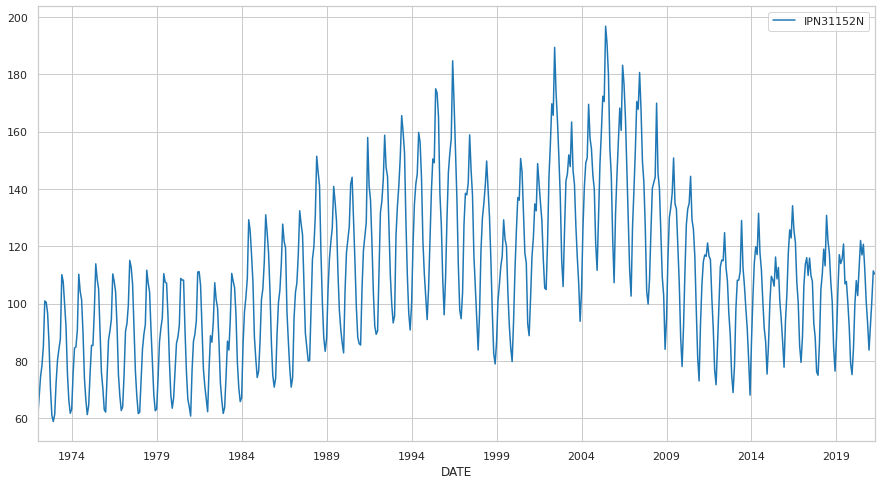

In [43]:
df.plot()

In [8]:
print(f'Number of months present - {len(df)}')
print(f'Number of years present - {len(df)/12}') # as each month has one observation

Number of months present - 592
Number of years present - 49.333333333333336


In [9]:
df.tail().index # only 4 months of data from the year 2020

DatetimeIndex(['2020-12-01', '2021-01-01', '2021-02-01', '2021-03-01',
               '2021-04-01'],
              dtype='datetime64[ns]', name='DATE', freq=None)

# 2.**Data Preparation**
---

## **Train Test Split**

In [61]:
test_len = 18 # Considering last 18 months as test set.

ind = len(df) - test_len
train = df[:ind] # 1972-01 to 2019-10
test = df[ind:] # 2019-11 to 2021-04

print(f'Length of train set: {len(train)}')
print(f'Length of test set: {len(test)}')

Length of train set: 574
Length of test set: 18


In [62]:
# Train data
train

,IPN31152N
DATE,
1972-01-01,60.1527
1972-02-01,67.2736
1972-03-01,74.4710
1972-04-01,78.3605
1972-05-01,85.0332
...,...
2019-06-01,120.7968
2019-07-01,106.8955
2019-08-01,107.7196


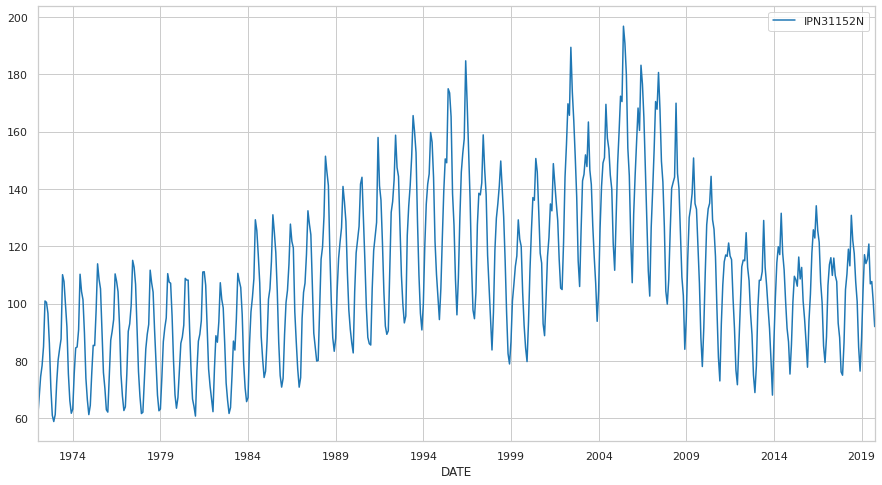

In [63]:
# Train Data plot
train.plot()

In [64]:
# Test Data
test

,IPN31152N
DATE,
2019-11-01,79.1450
2019-12-01,75.2130
2020-01-01,84.1969
2020-02-01,99.7767
2020-03-01,108.0301
2020-04-01,102.7954
2020-05-01,112.5288
2020-06-01,122.0301
2020-07-01,116.9799


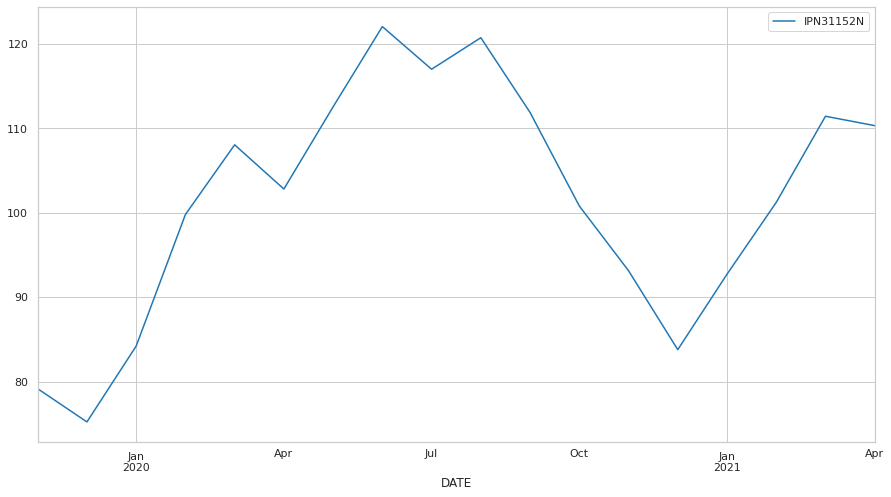

In [65]:
# Test Data Plot
test.plot()


## **Scaling Data**

In [15]:
# Scaling Test and Train Data
sc = MinMaxScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

## **Building Train and Test Generators**

In [16]:
inp_len = 12 # Generator takes 12 points as X_train and
out_len = 1 # takes next point as y_train
n_feat = 1

# Train Generator
train_gen = TimeseriesGenerator(data = train_sc,
                                targets = train_sc,
                                length = inp_len,
                                batch_size = out_len)

# Test Generator
test_gen = TimeseriesGenerator(data = test_sc,
                                targets = test_sc,
                                length = inp_len,
                                batch_size = out_len)

In [17]:
print(f'Length of Train set: {len(train)}')
print(f'Length of Train Generator:{len(train_gen)}') # Note: Generator will exclude last "inp_len (12)" points.
print(f'Length of Test set: {len(test)}')
print(f'Length of Test Generator:{len(test_gen)}')

Length of Train set: 574
Length of Train Generator:562
Length of Test set: 18
Length of Test Generator:6


> Understanding a Generator (train_gen)

In [18]:
X, y = train_gen[0] # First gen object
print(f'First train_gen object input (X): {len(X[0])}\n {X}\n') # 'inp_len' data points
print(f'First train_gen object output (y): {len(y[0])}\n {y}') # 'out_len' data points

First train_gen object input (X): 12
 [[[0.00946848]
  [0.06107908]
  [0.11324413]
  [0.1414343 ]
  [0.18979645]
  [0.30491195]
  [0.30149681]
  [0.27411766]
  [0.19733775]
  [0.08531415]
  [0.01561386]
  [0.        ]]]

First train_gen object output (y): 1
 [[0.01773963]]


In [19]:
# Actual scaled train set
train_sc[:inp_len+out_len]

array([[0.00946848],
       [0.06107908],
       [0.11324413],
       [0.1414343 ],
       [0.18979645],
       [0.30491195],
       [0.30149681],
       [0.27411766],
       [0.19733775],
       [0.08531415],
       [0.01561386],
       [0.        ],
       [0.01773963]])

# 3.**Model Building**
---

In [20]:
# Creating Model
model = Sequential()

# Input layer
model.add(LSTM(150, activation='relu', input_shape=(inp_len, n_feat))) #LSTM RNN
model.add(Dropout(0.15))
# Output layer
model.add(Dense(1))

In [21]:
# Compile the created model
model.compile(optimizer='adam',
              loss='mse')

# Monitor the "validation_loss" and 
# when "min" value is reached during training, wait for "2" epochs and stop training.
early_stop = EarlyStopping(monitor='val_loss',
                           verbose=1,
                           mode='min',
                           patience=2)

# Fit the model to the generators created.
model.fit_generator(train_gen,
                    validation_data = test_gen,
                    epochs = 10,
                    callbacks = [early_stop])

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


562/562 [==============================] - 13s 20ms/step - loss: 0.0246 - val_loss: 0.0038
Epoch 2/10
562/562 [==============================] - 11s 19ms/step - loss: 0.0115 - val_loss: 0.0015
Epoch 3/10
562/562 [==============================] - 11s 19ms/step - loss: 0.0083 - val_loss: 0.0018
Epoch 4/10
562/562 [==============================] - 11s 20ms/step - loss: 0.0070 - val_loss: 0.0012
Epoch 5/10
562/562 [==============================] - 11s 20ms/step - loss: 0.0059 - val_loss: 0.0029
Epoch 6/10
562/562 [==============================] - 11s 20ms/step - loss: 0.0062 - val_loss: 0.0016
Epoch 00006: early stopping


In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 150)               91200     
_________________________________________________________________
dropout (Dropout)            (None, 150)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


#4.**Evaluation**
---


## **Training and Validation Losses**

In [23]:
# New dataframe "losses" with model.history.history data
losses = pd.DataFrame(model.history.history)
losses

,loss,val_loss
0,0.024561,0.003833
1,0.011451,0.001484
2,0.008326,0.001824
3,0.007043,0.001163
4,0.005948,0.002940
5,0.006212,0.001577


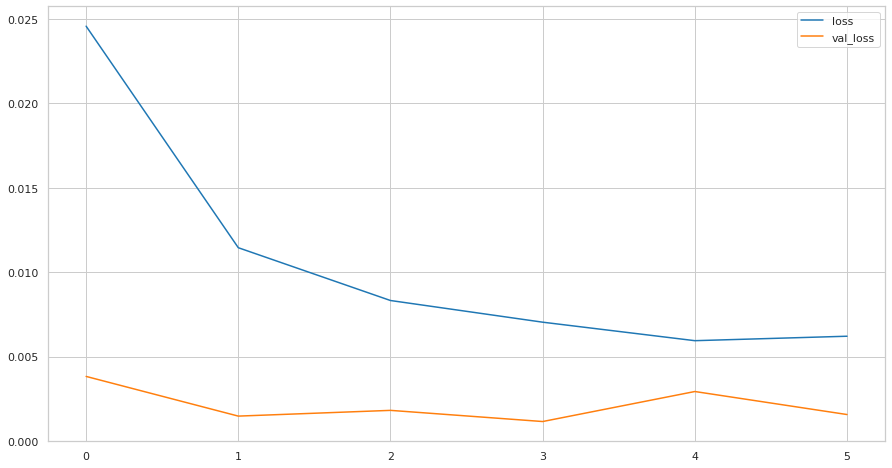

In [53]:
# Plot training loss v/s validation loss
losses[['loss','val_loss']].plot()

## **Predictions**

Idea here for the predictions is,
first, we predict the last batch that was not included in train_gen, 
then first row is discarded and predicted values are added at last as illustrated below, and this repeats till the length of testset.
>

> ```
1. [x1 x2 x3 x4 x5] -> M -> [y1] 
2. [x2 x3 x4 x5 y1] -> M -> [y2]
3. [x3 x4 x5 y1 y2] -> M -> [y3] 
          .
          .
          .     
n. [y1 y2 y3 y4 y5] -> M -> [y6] # Predicting on Predictions
```




In [25]:
y_pred = [] 

train_sc_lastrows = train_sc[-inp_len:] # Last row of scaled train (excluded by train_gen)
batch = train_sc_lastrows.reshape((1, inp_len, n_feat)) # Reshape (1, 12, 1)

for _ in range(len(test)):
  pred = model.predict(batch) # Predict 
  y_pred.append(pred[0]) # Append the 'prediction' to empty list
  batch = np.append(batch[:,1:,:],[pred],axis=1) # Remove first element in 'batch', add prediction at end, and Repeat predictions.

In [26]:
y_pred = sc.inverse_transform(y_pred) # Remove scaling
test['y_pred'] = y_pred # Adding the predictions to test data for comparision

test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,IPN31152N,y_pred
DATE,,
2019-11-01,79.1450,87.259898
2019-12-01,75.2130,83.331891
2020-01-01,84.1969,90.553906
2020-02-01,99.7767,101.994070
2020-03-01,108.0301,108.082919
2020-04-01,102.7954,110.218357
2020-05-01,112.5288,113.463976
2020-06-01,122.0301,113.030533
2020-07-01,116.9799,108.856028


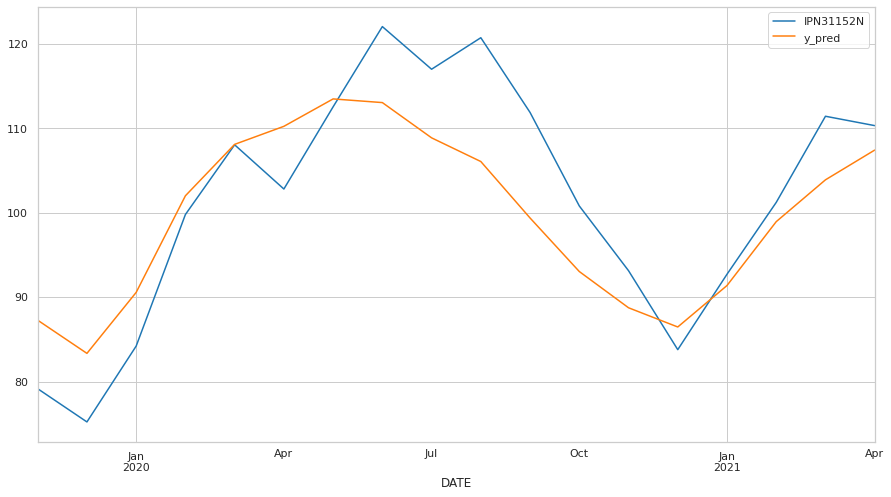

In [59]:
test.plot() # Original Test Data vs Predictions

# Note: LSTM produce different results on each execution

In [28]:
rmse = mean_squared_error(test['IPN31152N'],test['y_pred'])**0.5
df_mean = df['IPN31152N'].mean()
print(f'RMSE : {rmse}')
print(f'Mean : {df_mean}')
print(f'Scatter Index: {rmse/df_mean}') # Less SI -> Better Model

RMSE : 7.110599029738639
Mean : 109.921170945946
Scatter Index: 0.06468816669752629


# 5.**Forecasting**
---

Accepting the preceding model's performance, Creating a new model with same parameters and fitting on all the available data for forecasting next 12 months.

In [29]:
scaler = MinMaxScaler() 
sc_df = scaler.fit_transform(df) # Scaling complete data

# Generator
gen = TimeseriesGenerator(sc_df,  
                          sc_df,
                          length=inp_len,
                          batch_size = out_len)

# Model
forecaster = Sequential()
forecaster.add(LSTM(150, activation='relu', input_shape=(inp_len, n_feat)))
forecaster.add(Dropout(0.15))
forecaster.add(Dense(1))

# Compile the created model
forecaster.compile(optimizer='adam', loss='mse')

# Fit the model
forecaster.fit_generator(gen, epochs = 5)


interval = 12 # Forecasting Period
forecast = []
sc_df_lastrows = sc_df[-inp_len:]
batch1 = sc_df_lastrows.reshape((1, inp_len, n_feat))
for _ in range(interval):
  pred1 = forecaster.predict(batch1)
  forecast.append(pred1[0]) 
  batch1 = np.append(batch1[:,1:,:],[pred1],axis=1)

forecast = scaler.inverse_transform(forecast)

# Creating new DataFrame with Index of future dates
fc_index = pd.date_range(start='2021-05-01', periods=interval, freq='MS')
fc_df = pd.DataFrame(forecast, index=fc_index, columns=['Forecast'])
fc_df # Forecast Dataframe

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


580/580 [==============================] - 12s 19ms/step - loss: 0.0213
Epoch 2/5
580/580 [==============================] - 11s 19ms/step - loss: 0.0107
Epoch 3/5
580/580 [==============================] - 11s 19ms/step - loss: 0.0081
Epoch 4/5
580/580 [==============================] - 11s 20ms/step - loss: 0.0065
Epoch 5/5
580/580 [==============================] - 11s 19ms/step - loss: 0.0056


,Forecast
2021-05-01,120.190590
2021-06-01,124.640829
2021-07-01,126.139711
2021-08-01,124.750120
2021-09-01,115.634461
2021-10-01,103.302307
2021-11-01,91.854916
2021-12-01,86.205361
2022-01-01,91.444939
2022-02-01,101.272097


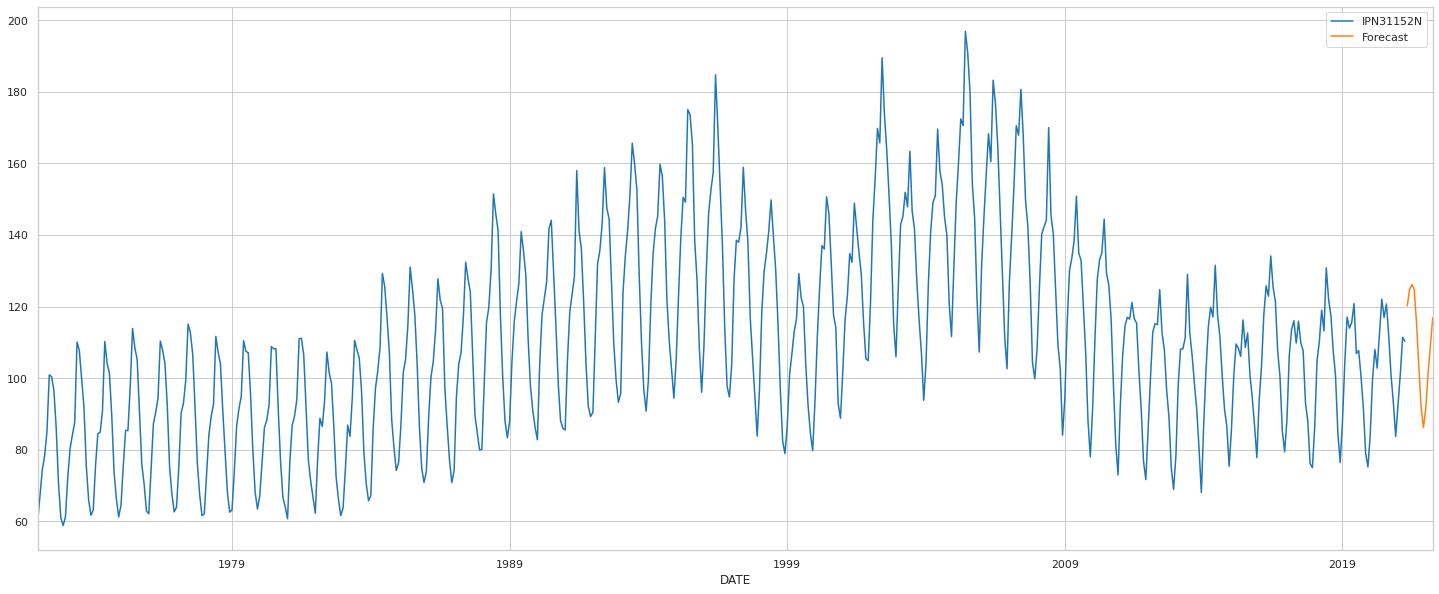

In [48]:
# Complete Graph with Forecasting
ax = df.plot()
fc_df.plot(ax=ax, figsize=(25,10))

(588.0, 627.0)

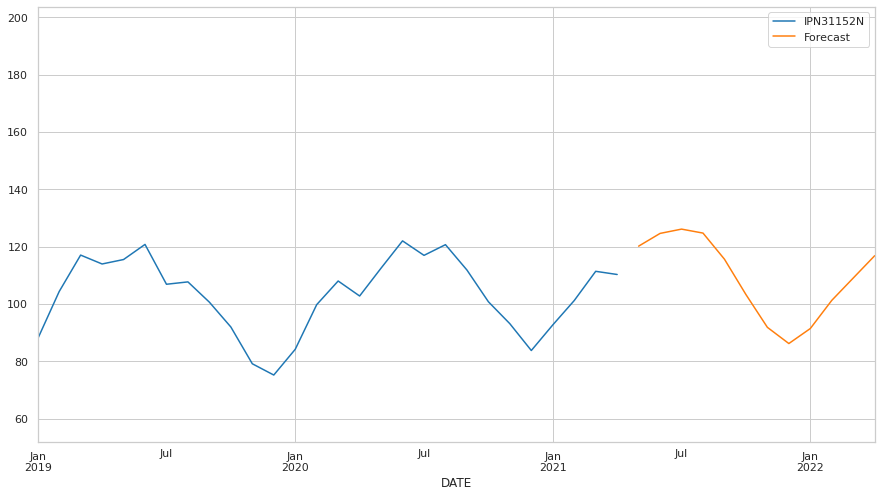

In [49]:
# Forecasting Graph (cropped)
ax = df.plot()
fc_df.plot(ax=ax)
plt.xlim('2019-01-01', fc_index[-1])